In [1]:
%pylab inline
import scipy
import sys
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils
from pyiga import assemble as Ass
from patchmesh import *
from patchmesh3D import *
import itertools as it
#from multipatch import *

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rref(B, tol=1e-8, debug=False):
    A = B.copy()
    rows, cols = A.shape
    r = 0
    pivots_pos = []
    row_exchanges = np.arange(rows)
    for c in range(cols):
        if debug: print("Now at row", r, "and col", c, "with matrix:"); print (A)

        ## Find the pivot row:
        pivot = np.argmax (np.abs (A[r:rows,c])) + r
        m = np.abs(A[pivot, c])
        if debug: print("Found pivot", m, "in row", pivot)
        if m <= tol:
            ## Skip column c, making sure the approximately zero terms are
            ## actually zero.
            if len(A[r:rows,c].shape)==1:
                A[r:rows, c] = np.zeros(rows-r)
            else:
                A[r:rows, c] = np.zeros((rows-r,1))
            if debug: print("All elements at and below (", r, ",", c, ") are zero.. moving on..")
        else:
            ## keep track of bound variables
            pivots_pos.append((r,c))

            if pivot != r:
                ## Swap current row and pivot row
                A[[pivot, r], c:cols] = A[[r, pivot], c:cols]
                row_exchanges[[pivot,r]] = row_exchanges[[r,pivot]]
        
                if debug: print("Swap row", r, "with row", pivot, "Now:"); print(A)

            ## Normalize pivot row
            A[r, c:cols] = A[r, c:cols] / A[r, c];

            ## Eliminate the current column
            v = A[r, c:cols]
            ## Above (before row r):
            if r > 0:
                ridx_above = np.arange(r)
                A[ridx_above, c:cols] = A[ridx_above, c:cols] - np.outer(v, A[ridx_above, c]).T
                if debug: print("Elimination above performed:"); print(A)
            ## Below (after row r):
            if r < rows-1:
                ridx_below = np.arange(r+1,rows)
                A[ridx_below, c:cols] = A[ridx_below, c:cols] - np.outer(v, A[ridx_below, c]).T
                if debug: print("Elimination below performed:"); print(A)
            r += 1
        ## Check if done
            if r == rows:
                break;
#         for r in reversed(range(rows)):
#             if scipy.linalg.norm(A[r,:]) > tol:
#                 break
    return (A, pivots_pos, row_exchanges)

In [3]:
def basis_for_nullspace_of_dense_SVD(constr):
    '''Derives a matrix representing a basis for the nullspace of a dense matrix using SVD'''
    result = scipy.linalg.null_space(constr)
    # Scaling: Largest entry should be 1
    for i in range(result.shape[1]):
        mx = result[:,i].max()
        mn = result[:,i].min()
        if mx > -mx:
            result[:,i] /= mx
        else:
            result[:,i] /= mn
    return result.transpose()

def basis_for_nullspace_of_dense_LU(constr, tol=1e-8, idx=None):
    '''Derives a matrix representing a basis for the nullspace of a dense matrix using LU'''
    #P,L,U = scipy.linalg.lu(constr)
    U, _, _ = rref(constr, tol=tol)
    r,c = U.shape
    #print(r,c)
    # Remove (almost) empty rows
    for i in range(r-1,-1,-1):
        if (abs(U[i,:])<tol).all():
            U = np.delete(U,i,0)
    r,c = U.shape
    #print(U)
    # Swap cols if necessary
    perm = np.arange(c)
    for i in range(r):
        if abs(U[i,i])<tol:
            #mx = np.abs(U[i,i+1:]).max()
            j = i
            while abs(U[i,j]) < tol:
                 j += 1
#             j=i
#             while abs(U[i,j])<tol:
#                 j+=1
            perm[i], perm[j] = perm[j], perm[i]
            U[:,[i,j]] = U[:,[j,i]]
    # Split matrix U and resolve linear system
    #print(U)
    U1 = U[:,:r]
    U2 = U[:,r:]
    sol = scipy.linalg.lu_solve((U1,np.arange(r)),U2)
    # Setup result
    result = np.zeros((c,c-r))
    result[:r,:] = -sol
    result[r:,:] = np.eye(c-r)    
    # Apply perm
    result2=result.copy()
    result[list(perm)] = result2
    # Scaling: Largest entry should be 1
#     for i in range(result.shape[1]):
#         mx = result[:,i].max()
#         mn = result[:,i].min()
#         if mx > -mx:
#             result[:,i] /= mx
#         else:
#             result[:,i] /= mn
    if idx is not None:
        if len(idx)>result.shape[1]:
            idx = idx[range(result.shape[1])]
        S=result.T[:,idx]
        return scipy.linalg.solve(S,result.T)

    return result.T

def get_connected_components(constr):
    '''Derives all connected components of the graph, where cols of matrix are nodes'''
    assert isinstance(constr, scipy.sparse.csr_matrix)
    (r, c) = constr.shape
    
    if not constr.has_sorted_indices:
        constr.sort_indices()
    
    comps = np.arange(c)
    for i in range(r):
        smallest_index = c
        for j in range(constr.indptr[i], constr.indptr[i+1]):
            smallest_index = min(smallest_index, comps[constr.indices[j]])
        for j in range(constr.indptr[i], constr.indptr[i+1]):
            comps[constr.indices[j]] = smallest_index        
    
    for i in range(c):
        if comps[comps[i]] < comps[i]:
            comps[i] = comps[comps[i]]
        
    constr_list = {}
    for i in range(r):
        comp = comps[constr.indices[constr.indptr[i]]]
        if comp not in constr_list:
            constr_list[comp] = []         
        constr_list[comp].append(i)
        
    comp_list = {}
    coupled = np.zeros(c,'b')
    for i in range(c):
        comp = comps[i]
        if comp != i or comp in constr_list.keys():
            if not comp in comp_list:
                comp_list[comp] = [comp]
            if comp != i:
                comp_list[comp].append(i)
            coupled[i] = True
    
#     print("coupled     =",coupled)
#     print("comp_list   =",comp_list)
#     print("constr_list =",constr_list)
    
    return coupled, comp_list, constr_list

def basis_for_nullspace(constr, basis_for_nullspace_of_dense=basis_for_nullspace_of_dense_SVD, idx=None):
    '''Derives a matrix representing a basis for the nullspace of a sparse matrix by first decomposing it into its connected components'''
    assert isinstance(constr, scipy.sparse.csr_matrix)
    (r, c) = constr.shape
    
    coupled, comp_list, constr_list = get_connected_components(constr)

    mat = scipy.sparse.lil_matrix((c,c))
    
    # First, take the free dofs as they are
    row = 0
    for i in range(c):
        if not coupled[i]:
            mat[row,i] = 1
            row += 1

    # TODO: Secondly, take the dofs with one-to-one mapping
    
    # Finally, take the other dofs
    for i in comp_list.keys():
        comp_item = comp_list[i]
        constr_item = constr_list[i]
        local_matrix = (constr[constr_item,:][:,comp_item]).A
        if idx is not None:
            loc_idx = np.array([i for i in range(len(comp_item)) if idx[comp_item[i]]==1])
        else:
            loc_idx=None
        local_basis  = basis_for_nullspace_of_dense(local_matrix, idx=loc_idx)
        #print( "local_matrix:\n", local_matrix )
        #print( "local_basis :\n", local_basis  )
        lb_rows, lb_cols = local_basis.shape
        for i0 in range(lb_rows):
            for j0 in range(lb_cols):
                mat[row,comp_item[j0]] = local_basis[i0,j0]
            row += 1

    mat.resize(row,c)
    return mat.tocsr()

In [4]:
def PoissonEstimator(MP,f,uh):
    n = MP.mesh.numpatches
    indicator = np.zeros(n)
    params = {'f': f}
    
    uh_per_patch = dict()
    
    #residual contribution
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        
        h = np.linalg.norm([b-a for a,b in geo.bounding_box()])
        
        N = tuple(kv.numdofs for kv in kvs)
        uh_per_patch[p] = (MP.global_to_patch(p) @ uh).reshape(N)   #cache Spline Function on patch p
        
        params['geo'] = geo
        params['uh_func'] = geometry.BSplineFunc(kvs, uh_per_patch[p])
        
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        indicator[p] = h**2 * np.sum(Ass.assemble('(f + div(grad(uh_func)))**2 * v * dx', kvs0, params))
        
    params = dict()
    
    #flux contribution
    for i,((p1,b1,_), (p2,b2,_), _, flip) in enumerate(MP.intfs):
        #print(p1, p2, flip)
        
        ((kvs1, geo1), _), ((kvs2, geo2), _) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = Ass.int_to_bdspec(b1), Ass.int_to_bdspec(b2)
        
        bkv1, bkv2 = Ass.boundary_kv(kvs1, bdspec1), Ass.boundary_kv(kvs2, bdspec2)

        geo = geo2.boundary(bdspec2)
        params['geo'] = geo
        
        kv0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in bkv2])
        h = np.sum(Ass.assemble('v * ds', kv0, params))
        
        params['uh_grad1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).transformed_jacobian(geo1).boundary(bdspec1, flip=flip) #physical gradient of uh on patch 1 (flipped if needed)
        params['uh_grad2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).transformed_jacobian(geo2).boundary(bdspec2)            #physical gradient of uh on patch 2
        #params['uh1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).boundary(bdspec1,flip=flip)
        #params['uh2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).boundary(bdspec2)
        normalflux_jump = np.sum(Ass.assemble('(inner(uh_grad1 - uh_grad2, n) )**2 * v * ds', kv0 ,params))
        #print(normalflux_jump)

        indicator[p1] += 0.5 * h * normalflux_jump
        indicator[p2] += 0.5 * h * normalflux_jump
    
    return np.sqrt(indicator)

def check_coupling(MP, u_):
    u_pp = dict()

    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        
        ((kvs1,_),_), ((kvs2,_),_) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = int_to_bdspec(b1), int_to_bdspec(b2)
        (kv1), (kv2) = boundary_kv(kvs1, bdspec1), boundary_kv(kvs2, bdspec2, flip=flip)
        dofs1, dofs2 = Ass.boundary_dofs(kvs1, bdspec1, ravel=True), Ass.boundary_dofs(kvs2, bdspec2, ravel=True, flip=flip)
        
        if p1 not in u_pp:
            u_pp[p1]=MP.global_to_patch(p1) @ u_
        if p2 not in u_pp:
            u_pp[p2]=MP.global_to_patch(p2) @ u_
          
        P = bspline.prolongation(kv1, kv2)
        u1, u2 = u_pp[p1][dofs1], u_pp[p2][dofs2]
        r=norm(u2 - P @ u1)
        
        if r>1e-8:
            return False
    return True

class Multipatch:
    """Represents a multipatch structure, consisting of a number of patches
    together with their discretizations and the information about shared dofs
    between patches. Nonconforming patches (both geometrically and knotwise non conforming) are allowed as long as there exists 
    a hierarchy between the interface knots

    Args:
        pm: A :class:`PatchMesh` instance representing the patches 
            via their discretization and their geometry function 
            as well as the generated mesh between the patches (vertices, interfaces).
            
        b_data: A dictionary of the form {'D':dir_data, 'N':neu_data, 'R': robin_data}
            dir_data: A list of triples (patch, bdspec, dir_func) prescribing the function `dir_func` to boundary dofs of `patch` on side `bdspec`.
            neu_data: A list of triples (patch, bdspec, neu_func) in order to assemble natural boundary conditions for boundary dofs of `patch` on side `bdspec`.
            robin_data: A list of triples (patch, bd_spec, (gamma, robin_func))
        
        automatch (bool): if True, attempt to automatically apply the interface information from the PatchMesh object to couple the patches.
            If False, the user has to manually join the patches by calling
            :meth:`join_boundaries` as often as needed, followed by
            :meth:`finalize`.
    """
    def __init__(self, pm, automatch=False, dim=2):
        """Initialize a multipatch structure."""
        # underlying PatchMesh object describing the geometry
        self.mesh = pm
        # enforced regularity across patch interfaces
        #self.k = k
        self.dim = dim 
            
        # number of tensor product dofs per patch
        self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod(n) for n in self.n]
        # offset to the dofs of the i-th patch
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        # per patch, a dict of shared indices
        self.shared_pp = dict(zip([p for p in range(self.mesh.numpatches)],self.mesh.numpatches*[set(),]))
        # a list of interfaces (patch1, boundary dofs1, patch2, boundary dofs2)
        self.intfs = set()
        self.Constr=scipy.sparse.csr_matrix((0,self.N_ofs[-1]))
        self.dof_class={dof:0 for dof in np.arange(self.N_ofs[-1])}

        if automatch:
            interfaces = self.mesh.interfaces.copy()
            
            for ((p1,bd1,s1),((p2,bd2,s2),flip)) in interfaces.items():
                if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                    self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
                
            #print(self.intfs)
            for ((p1,bd1,s1),(p2,bd2,s2), flip) in self.intfs:
                bdspec1 = (Ass.int_to_bdspec(bd1),)
                bdspec2 = (Ass.int_to_bdspec(bd2),)
                self.join_boundaries(p1, bdspec1, s1 , p2, bdspec2, s2, flip)
            #self.finalize()

    @property
    def numpatches(self):
        """Number of patches in the multipatch structure."""
        return len(self.mesh.patches)

    @property
    def numdofs(self):
        """Number of dofs after eliminating shared dofs.

        May only be called after :func:`finalize`.
        """
        return self.Basis.shape[0]
    
    @property
    def numloc_dofs(self):
        return self.N_ofs[-1]
    
    def reset(self, automatch = False):
        self.__init__(pm=self.mesh, b_data=self.b_data, dim=self.dim, automatch=automatch)

    def join_boundaries(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(self.dim-1)*(False,)
        
        bkv1 = Ass.boundary_kv(kvs1, bdspec1)
        bkv2 = Ass.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        dofs1 = Ass.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = Ass.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([bspline.is_sub_space(kv1,kv2) for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([bspline.is_sub_space(kv2,kv1) for kv1, kv2 in zip(bkv1,bkv2)]):          
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
        else:
            print('interface coupling not possible')
            
        for dof in dofs1:
            if self.dof_class[dof + self.N_ofs[p1]]==0:
                self.dof_class[dof + self.N_ofs[p1]]=1
        for dof in dofs2:
            self.dof_class[dof + self.N_ofs[p2]]=2
            
        self.shared_pp[p1]=self.shared_pp[p1] | set(dofs1)
        self.shared_pp[p2]=self.shared_pp[p2] | set(dofs2)
            
        #Prolongation operator  
        P = -scipy.sparse.coo_matrix(bspline.prolongation_tp(bkv1,bkv2))   #TODO: make paramater to generate prolongation matrix as coo_matrix directly?
        #construct constraints for this interface
        data = np.concatenate([P.data, np.ones(len(dofs2))])
        I = np.concatenate([P.row, np.arange(len(dofs2))])
        J = np.concatenate([dofs1[P.col] + self.N_ofs[p1],dofs2 + self.N_ofs[p2]])
        
        self.Constr = scipy.sparse.vstack([self.Constr,scipy.sparse.coo_matrix((data,(I,J)),(len(dofs2), self.numloc_dofs)).tocsr()])
        
           
    def finalize(self):
        """After all shared dofs have been declared using
        :meth:`join_boundaries` or :meth:`join_dofs`, call this function to set
        up the internal data structures.
        """
        num_shared = [len(self.shared_pp[p]) for p in range(self.numpatches)]
        # number of local dofs per patch
        self.M = [n - s for (n, s) in zip(self.N, num_shared)]
        # local-to-global offset per patch
        self.M_ofs = np.concatenate(([0], np.cumsum(self.M)))
        #TODO: self.Basis = basis_for_nullspace(self.Constr, basis_for_nullspace_of_dense_LU, idx=self.dof_class)
        #self.sanity_check()   

    def assemble_system(self, problem, rhs, args=None, bfuns=None,
            symmetric=False, format='csr', layout='blocked', **kwargs):
        """Assemble both the system matrix and the right-hand side vector
        for a variational problem over the multipatch geometry.

        Here `problem` represents a bilinear form and `rhs` a linear functional.
        See :func:`assemble` for the precise meaning of the arguments.

        Returns:
            A pair `(A, b)` consisting of the sparse system matrix and the
            right-hand side vector.
        """
        n = self.numdofs
        X=MP.Basis
        
        A = []
        b = []
        if args is None:
            args = dict()
        for p in range(self.numpatches):
            kvs, geo = self.mesh.patches[p][0]
            args.update(geo=geo)
            # TODO: vector-valued problems
            A.append(Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                    symmetric=symmetric, format=format, layout=layout,
                    **kwargs))
    
            b.append(Ass.assemble(rhs, kvs, args=args, bfuns=bfuns,
                    symmetric=symmetric, format=format, layout=layout,
                    **kwargs).ravel())
        A = X@scipy.sparse.block_diag(A)@X.T
        b = X@np.concatenate(b)
            
        return A, b
    
    def assemble_surface(self, problem, arity=1, boundary_idx=0, args=None, bfuns=None,
            symmetric=False, format='csr', layout='blocked', **kwargs):
        X = MP.Basis
        if args is None:
            args = dict()
        if arity==2:
            I, J, data = [], [], []
            for (p,b) in self.mesh.outer_boundaries[boundary_idx]:
                kvs, geo = self.mesh.patches[p][0]
                bdspec=[(b//2,b%2)]
                bdofs = Ass.boundary_dofs(kvs, bdspec, ravel=True) + self.N_ofs[p]
                args.update(geo = geo)
                
                R = Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format='coo', layout=layout,
                        **kwargs, boundary=bdspec)
                
                I_p ,J_p = R.row, R.col
                I.append(bdofs[I_p]), J.append(bdofs[J_p]), data.append(R.data)
                
            I, J, data = np.concatenate(I), np.concatenate(J), np.concatenate(data)
            R = scipy.sparse.coo_matrix((data, (I, J)), 2*(self.numloc_dofs,))
            return X @ scipy.sparse.csr_matrix(R) @ X.T
        else:
            N=np.zeros(self.numloc_dofs)
            for (p,b) in self.mesh.outer_boundaries[boundary_idx]:
                kvs, geo = self.mesh.patches[p][0]
                bdspec=[(b//2,b%2)]
                bdofs = Ass.boundary_dofs(kvs, bdspec, ravel=True) + self.N_ofs[p]
                args.update(geo = geo)
    
                vals=Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format=format, layout=layout,
                        **kwargs, boundary=bdspec).ravel()
                N[bdofs] += vals 
            
            return X @ N
            
    
#     def assemble_boundary(self, problem, boundary_idx = None, args=None, bfuns=None,
#             symmetric=False, format='csr', layout='blocked', **kwargs):
        
    
#     def C1_coupling(self, p1, bdspec1, p2, bdspec2, flip=None):
        
#         (ax1, sd1), (ax2, sd2) = bdspec1, bdspec2
#         ((kvs1, geo1),_), ((kvs2, geo2),_) = self.mesh.patches[p1], self.mesh.patches[p2]
#         sup1, sup2 = geo1.support, geo2.support
#         dim=len(kvs1)
#         if flip is None:
#             flip=(dim-1)*(False,)
 
#         bkv1, bkv2 = Ass.boundary_kv(kvs1, bdspec1), Ass.boundary_kv(kvs2, bdspec2)
#         dofs1, dofs2 = Ass.boundary_dofs(kvs1, bdspec1, ravel = True, k=1), Ass.boundary_dofs(kvs2, bdspec2, ravel = True, flip=flip, k=1)
#         G = tuple(kv.greville() for kv in kvs2)
#         G2 = G[:ax2] + (np.array([sup2[ax2][0] if sd2==0 else sup2[ax2][-1]]),) + G[ax2+1:]
#         G1 = G[:ax2] + G[ax2+1:]
#         G1 = G1[:ax1] + (np.array([sup1[ax1][0] if sd1==0 else sup1[ax1][-1]]),) + G1[ax1:] #still need to add flip

#         M=tuple(len(g) for g in G2)
#         m=np.prod(M)
#         n1,n2=len(dofs1), len(dofs2)
        
#         C1, D1 = bspline.collocation_derivs_tp(kvs1, G1, derivs=1)
#         C2, D2 = bspline.collocation_derivs_tp(kvs2, G2, derivs=1)
    
#         C1, C2 = C1[0].tocsr()[:,dofs1], C2[0].tocsr()[:,dofs2]
#         for i in range(dim):
#             D1[i], D2[i] = D1[i].tocsr()[:,dofs1], D2[i].tocsr()[:,dofs2]
#         N2=geo2.boundary(bdspec2).grid_outer_normal(G2[:ax2]+G2[ax2+1:]).reshape(m,dim)

#         J1=geo1.grid_jacobian(G1).reshape(m,dim,dim)
#         J2=geo2.grid_jacobian(G2).reshape(m,dim,dim)
        
#         invJ1=np.array([inv(jac) for jac in J1[:]])
#         invJ2=np.array([inv(jac) for jac in J2[:]])

#         NC1=scipy.sparse.csr_matrix((m, n1))
#         for i in range(dim):
#             NC1_ = scipy.sparse.csr_matrix((m, n1))
#             for j in range(dim):
#                 NC1_ += scipy.sparse.spdiags(invJ1[:,i,j], 0, m, m)*D1[dim-1-j]
#             NC1 += scipy.sparse.spdiags(N2[:,i], 0, m, m)*NC1_
            
#         NC2=scipy.sparse.csr_matrix((m, n2))
#         for i in range(dim):
#             NC2_ = scipy.sparse.csr_matrix((m, n2))
#             for j in range(dim):
#                 NC2_ += scipy.sparse.spdiags(invJ2[:,i,j], 0, m, m)*D2[dim-1-j]
#             NC2 += scipy.sparse.spdiags(N2[:,i], 0, m, m)*NC2_
            
#         A = scipy.sparse.vstack([C1, NC1])
#         B = scipy.sparse.vstack([C2, NC2])
#         P = scipy.sparse.linalg.spsolve(B,A.A)
#         # prune matrix
#         P[np.abs(P) < 1e-15] = 0.0
#         return scipy.sparse.csr_matrix(P) 
        
    def L2Projection(self, u):
        M, rhs, _, _, _ = self.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f=u)
        u_ = solvers.make_solver(M, spd=True).dot(rhs)
        return u_
    
    def refine(self, patches=None, mult=1, return_prol=False):
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
            patches = patches.keys()
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
        elif patches==None:
            patches = np.arange(self.numpatches)
        elif np.isscalar(patches):
            patches=(patches,)
        else:
            assert 0, "unknown input type"
        if return_prol:
            n=self.numdofs
            old_kvs=[kvs for (kvs,_),_ in self.mesh.patches]
            old_global_to_patch = [self.global_to_patch(p) for p in range(self.numpatches)]
            
        self.mesh.refine(patches, mult=mult)
        self.reset(automatch=True)
        #MP = Multipatch(self.mesh, automatch=True, k=self.k)
        
        if return_prol:
            m = self.numdofs
            P = scipy.sparse.csr_matrix((m, n))
            
            for p in range(self.numpatches):
                if p in patches:
                    kvs=old_kvs[p]
                    new_kvs=MP.mesh.patches[p][0][0]
                    C = bspline.prolongation_tp(kvs, new_kvs)
                else:
                    C = scipy.sparse.identity(self.N[p])

                P += MP.patch_to_global(p) @ C @ old_global_to_patch[p]
            factors = [1/sum([sum(dof[p][1]) for p in dof]) for dof in MP.shared_dofs]
            P[MP.M_ofs[-1]:] = scipy.sparse.spdiags(factors, 0, len(factors), len(factors)) @ P[MP.M_ofs[-1]:]
            return P
        
    def patch_refine(self, patches=None, mult=1, return_prol = False):
        """Refines the Mesh by splitting patches
        
        The dictionary `patches` specifies which patches (dict keys) are to be split 
        and how to split them (dict values: 0 to dim-1 or None)
        
        The `return_prol` keyword enables also the generation of a prolongation matrix from one mesh to the split mesh.
        
        Returns:
            A new :class:`Multipatch` object `MP`
            A sparse matrix `P` suitable for prolongation.
        """
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
        elif isinstance(patches,int):
            #assert patches >=0 and patches < self.dim, "dimension error."
            patches = {p:patches for p in range(self.numpatches)}
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
            patches = {p:None for p in patches}
        elif patches==None:
            patches = {p:None for p in range(self.numpatches)}
        else:
            assert 0, "unknown input type"
        
        #n=self.numdofs
        N=self.numpatches

        #M = copy.deepcopy(self.mesh)
        #old_kvs = [kvs for (kvs,_),_ in self.mesh.patches]
       # old_global_to_patch = [self.global_to_patch(p) for p in range(self.numpatches)]
        
        new_patches = dict()
        new_kvs_ = dict()
        for p in patches.keys():
            self.split_boundary_data(p, self.numpatches, axis=patches[p])
            new_patches[p], new_kvs_[p] = self.mesh.split_patch(p, axis=patches[p], mult=mult)
        
        #MP = Multipatch(self.mesh, automatch=True, k=self.k)
        self.reset(automatch=True)
        #m = self.numdofs
        
        if return_prol:
            P = scipy.sparse.csr_matrix((m, n))
            for p in range(N):
                kvs=old_kvs[p]
                if p in new_patches:
                    new_kvs = new_kvs_[p]
                    S = scipy.sparse.csr_matrix((m,bspline.numdofs(new_kvs)))
                    C =  bspline.prolongation_tp(kvs, new_kvs)
                    
                    for i, new_p in enumerate(new_patches[p]):
                    
                        val = np.ones(self.N[new_p])
                        I = np.arange(self.N[new_p])
                        
                        if patches[p]==0:
                            bdspec = (0,i)
                            k = self.mesh.patches[new_p][0][0][0].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,bdspec,ravel=True,k=k-1))
                        elif patches[p]==1:
                            bdspec = (1,i)
                            k = self.mesh.patches[new_p][0][0][1].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,bdspec,ravel=True,k=k-1))
                        else:
                            cspec=(i//2,i%2)
                            k0=self.mesh.patches[new_p][0][0][0].numdofs
                            k1=self.mesh.patches[new_p][0][0][1].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,cspec,k=[k0-1,k1-1], ravel=True))
               
                        R = scipy.sparse.coo_matrix((val,(I,J)),shape=(self.N[new_p],bspline.numdofs(new_kvs)))
                        S += self.patch_to_global(new_p) @ R
                else:
                    S=self.patch_to_global(p)
                    C=scipy.sparse.identity(self.N[p])
                
                P += S @ C @ old_global_to_patch[p]
                
            factors = [1/sum([sum(dof[p][1]) for p in dof]) for dof in self.shared_dofs]
            P[self.M_ofs[-1]:] = scipy.sparse.spdiags(factors, 0, len(factors), len(factors)) @ P[self.M_ofs[-1]:]
            return P
        
#     def split_boundary_data(self, p, n, axis = None):
#         """Splits the boundary information of a patch `p`.
    
#         Args:
#             p: patch to be split
#             n: total number of patches
#             dir_data: information of the Dirichlet condition over the whole PatchMesh structure
            
#         Returns:
#             Modified list `dir_data` with split patches.
#         """
#         if axis==None:
#             axis=tuple(range(self.dim))
#         axis=np.unique(axis)
#         if len(axis)==1: axis=axis[0]
#         for s in self.b_data.keys():
            
#             b_data_p = [(patch , bd, g) for (patch, bd, g) in self.b_data[s] if patch == p]
            
#             if b_data_p:
#                 if not np.isscalar(axis):
#                     for k,ax in enumerate(axis[::-1]):
#                         self.split_boundary_data(p, n+2**k-1, axis=ax)
#                         for i in range(2**k-1):
#                             self.split_boundary_data(n+i, n+2**k+i, axis=ax)
#                 else:
#                     for (patch, bd, g) in b_data_p:
#                         if self.dim==3:
#                             if axis == self.dim - 3:
#                                 if bd == 'back':
#                                     self.b_data[s].remove((patch, bd, g))
#                                     self.b_data[s].append((n, bd, g))
#                                 if bd == 'left' or bd == 'right' or bd == 'bottom' or bd=='top':
#                                     self.b_data[s].append((n, bd, g))
#                         if axis == self.dim - 2:
#                             if bd == 'top':
#                                 self.b_data[s].remove((patch, bd, g))
#                                 self.b_data[s].append((n, bd, g))
#                             if bd == 'left' or bd == 'right':
#                                 self.b_data[s].append((n, bd, g))
#                             if self.dim == 3:
#                                 if bd == 'front' or bd == 'back':
#                                     self.b_data[s].append((n, bd, g)) 
#                         if axis == self.dim - 1:
#                             if bd == 'right':
#                                 self.b_data[s].remove((patch, bd, g))
#                                 self.b_data[s].append((n, bd, g))   
#                             if bd == 'bottom' or bd == 'top':
#                                 self.b_data[s].append((n, bd, g))
#                             if self.dim == 3:
#                                 if bd == 'front' or bd == 'back':
#                                     self.b_data[s].append((n, bd, g)) 

    def compute_dirichlet_bcs(self):
        """Performs the same operation as the global function
        :func:`compute_dirichlet_bcs`, but for a multipatch problem.

        The sequence `dir_data` should contain triples of the form `(patch,
        bdspec, dir_func)`.

        Returns:
            A pair `(indices, values)` suitable for passing to
            :class:`RestrictedLinearSystem`.
        """
        bcs = []
        p2g = dict()        # cache the patch-to-global indices for efficiency
        for (p, bdspec, g) in self.b_data['D']:
            (kvs, geo), _ = self.mesh.patches[p]
            bc = Ass.compute_dirichlet_bc(kvs, geo, bdspec, g)
            if p not in p2g:
                p2g[p] = self.patch_to_global_idx(p)
            idx = p2g[p]    # maps local dofs to global dofs
            bcs.append((*idx[bc[0],0].toarray().T, bc[1]))
        return Ass.combine_bcs(bcs)
    
    def sanity_check(self):
        for p in range(self.numpatches):
            assert all([np.isclose(sum(coeffs),1.0) for _,coeffs in self.shared_per_patch[p].values()]), 'coupling of dofs is flawed'

In [44]:
#Example 1

#setup initial discretization 
deg = 9
N = 1
kvs = 2*[3*(bspline.make_knots(deg,0.0,1.0,N),),]

# define geometry
geos = [
    geometry.unit_cube(),
    geometry.unit_cube().translate((1,0,0))
]

patches = [(k, g) for k, g in zip(kvs,geos)]
M = PatchMesh3D(patches)
#M.refine(patches=1)

g = lambda x,y: x
#g=u

#dir_data = [
#    (0, 'bottom', g), (0, 'left', g), (0, 'top', g),
#    (1, 'right', g), (1, 'bottom', g), (1, 'top', g)
#]

#M.split_patches()

#for t in [{1:0},{2:0},{3:1},{4:0}]:
#    print(t)
#    M.split_patches(t)

for i in range(6):
    number = math.floor(random.rand()*M.numpatches)
    direction = math.floor(random.rand()*3)
    print(number, direction)   
    M.split_patches({number:direction})

MP=Multipatch(M, automatch=True)
#MP.patch_refine(patches={1:0})
#MP.refine(patches={0})
#MP.reset(automatch=True)
MP.finalize()

1 1
1 2
2 1
4 2
4 1
2 0


TypeError: 'NoneType' object is not iterable

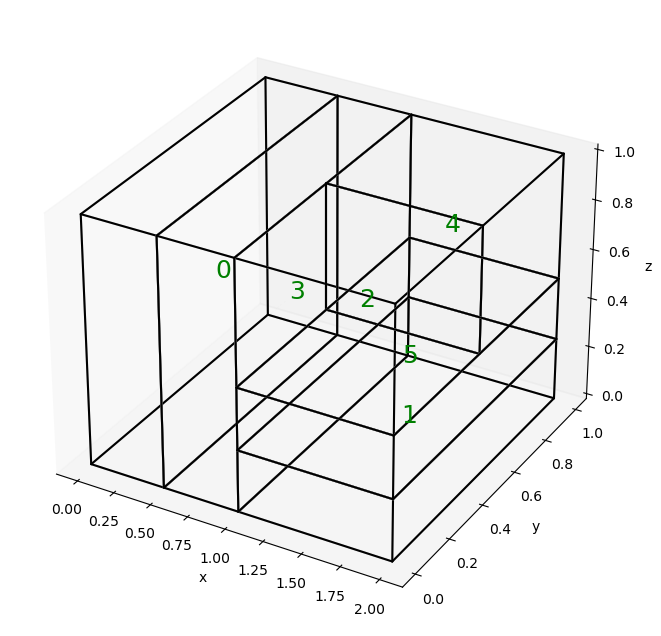

In [6]:
M.draw(patch_idx=True)

In [7]:
#MP.Basis = basis_for_nullspace(MP.Constr, basis_for_nullspace_of_dense_LU, idx=MP.dof_class)

In [8]:
#if (np.abs(MP.Constr@MP.Basis.T)).sum()>1e-10:
#    print("Method failed!")

In [9]:
#Try now without dof classification
MP.Basis = basis_for_nullspace(MP.Constr, basis_for_nullspace_of_dense_LU)
MP.Basis.shape

(5139, 6000)

In [10]:
if (np.abs(MP.Constr@MP.Basis.T)).sum()>1e-7:
    print("Method failed!",(np.abs(MP.Constr@MP.Basis.T)).sum())

Method failed! 99.00000000000006


In [11]:
#Try now without dof classification
MP.Basis = basis_for_nullspace_of_dense_LU(MP.Constr.todense())
MP.Basis.shape

(5149, 6000)

In [12]:
if (np.abs(MP.Constr@MP.Basis.T)).sum()>1e-7:
    print("Method failed!",(np.abs(MP.Constr@MP.Basis.T)).sum())

Method failed! 0.00010798741068806207


In [13]:
MP.Constr.shape

(900, 6000)

In [14]:
allLocalDofs = MP.Constr.shape[1]

In [15]:
constr = MP.Constr.copy()

In [16]:
for r in range(constr.shape[0]):
    a = 0
    b = 0
    for ind in range(constr.indptr[r], constr.indptr[r+1]):
        v = constr.data[ind]
        if v > 1e-13:
            a += 1
        if v < -1e-13:
            b += 1
    print("{}: {}, {}".format(r,a,b))
    if not (a==1 or b==1):
        print( "Assertion failed" )
    elif a!=1:
        print( "Re-sign" )
        constr[r,:] *= -1

0: 1, 10
1: 1, 10
2: 1, 10
3: 1, 10
4: 1, 10
5: 1, 10
6: 1, 10
7: 1, 10
8: 1, 10
9: 1, 10
10: 1, 9
11: 1, 9
12: 1, 9
13: 1, 9
14: 1, 9
15: 1, 9
16: 1, 9
17: 1, 9
18: 1, 9
19: 1, 9
20: 1, 8
21: 1, 8
22: 1, 8
23: 1, 8
24: 1, 8
25: 1, 8
26: 1, 8
27: 1, 8
28: 1, 8
29: 1, 8
30: 1, 7
31: 1, 7
32: 1, 7
33: 1, 7
34: 1, 7
35: 1, 7
36: 1, 7
37: 1, 7
38: 1, 7
39: 1, 7
40: 1, 6
41: 1, 6
42: 1, 6
43: 1, 6
44: 1, 6
45: 1, 6
46: 1, 6
47: 1, 6
48: 1, 6
49: 1, 6
50: 1, 5
51: 1, 5
52: 1, 5
53: 1, 5
54: 1, 5
55: 1, 5
56: 1, 5
57: 1, 5
58: 1, 5
59: 1, 5
60: 1, 4
61: 1, 4
62: 1, 4
63: 1, 4
64: 1, 4
65: 1, 4
66: 1, 4
67: 1, 4
68: 1, 4
69: 1, 4
70: 1, 3
71: 1, 3
72: 1, 3
73: 1, 3
74: 1, 3
75: 1, 3
76: 1, 3
77: 1, 3
78: 1, 3
79: 1, 3
80: 1, 2
81: 1, 2
82: 1, 2
83: 1, 2
84: 1, 2
85: 1, 2
86: 1, 2
87: 1, 2
88: 1, 2
89: 1, 2
90: 1, 1
91: 1, 1
92: 1, 1
93: 1, 1
94: 1, 1
95: 1, 1
96: 1, 1
97: 1, 1
98: 1, 1
99: 1, 1
100: 1, 10
101: 1, 10
102: 1, 10
103: 1, 10
104: 1, 10
105: 1, 10
106: 1, 10
107: 1, 10
108: 1, 10
1

In [17]:
derivedDofs = {}

for r in range(constr.shape[0]):
    dofToBeEliminated = -1
    feasible = True
    for ind in range(constr.indptr[r], constr.indptr[r+1]):
        c = constr.indices[ind]
        v = constr.data[ind]
        if v > 1e-13: # We DO NOT know that there is only one (see INEXISTING assertion above!)
            if dofToBeEliminated!=-1:
                if feasible:
                    print("constraint #{} cannot be handled because it has more than 1 positive entry.".format(r))
                feasible = False
            dofToBeEliminated = c
    assert(dofToBeEliminated>-1)
    for ind in range(constr.indptr[r], constr.indptr[r+1]):
        c = constr.indices[ind]
        v = constr.data[ind]
        if v < -1e-13 and c in derivedDofs:
            print("{} cannot be eliminated (constraint #{}) because it refers to eliminated dof {}.".format(dofToBeEliminated,r,c))
            feasible = False
    if dofToBeEliminated in derivedDofs:
        print("{} cannot be eliminated (constraint #{}) because it is already eliminated.".format(dofToBeEliminated,r))
        feasible = False
    if feasible:
        derivedDofs[dofToBeEliminated] = r

for i, _ in derivedDofs.items():
    print(i, end=', ')

4000 cannot be eliminated (constraint #300) because it refers to eliminated dof 2090.
4000 cannot be eliminated (constraint #300) because it is already eliminated.
4001 cannot be eliminated (constraint #301) because it is already eliminated.
4002 cannot be eliminated (constraint #302) because it is already eliminated.
4003 cannot be eliminated (constraint #303) because it is already eliminated.
4004 cannot be eliminated (constraint #304) because it is already eliminated.
4005 cannot be eliminated (constraint #305) because it is already eliminated.
4006 cannot be eliminated (constraint #306) because it is already eliminated.
4007 cannot be eliminated (constraint #307) because it is already eliminated.
4008 cannot be eliminated (constraint #308) because it is already eliminated.
4009 cannot be eliminated (constraint #309) because it is already eliminated.
4100 cannot be eliminated (constraint #310) because it refers to eliminated dof 2190.
4200 cannot be eliminated (constraint #320) beca

In [18]:
lBasis = scipy.sparse.lil_matrix((allLocalDofs,allLocalDofs)) #coo_matrix ?

for i in range(allLocalDofs):
    if not i in derivedDofs:
        lBasis[i,i] = 1
        
#for i, r in derivedDofs.items():
#    for c in range(allLocalDofs): 
#        v = constr[r,c]
#        if v < -1e-14:
#            lBasis[i,c] = - v / constr[r,i]

for i, r in derivedDofs.items():
    for ind in range(constr.indptr[r], constr.indptr[r+1]):
        c = constr.indices[ind]
        v = constr.data[ind]    
        if v < -1e-14:
            lBasis[i,c] = - v / constr[r,i]

lBasis = lBasis.tocsr()

In [19]:
lastFound = allLocalDofs+1
testVec = np.zeros(allLocalDofs)
for i in derivedDofs.keys():
    testVec[i] = 1
while True:
    found = 0
    tmp = lBasis * testVec
    for i in range(allLocalDofs):
        if abs(tmp[i])>1e-13:
            print('{}'.format(i))
            found += 1
    if found > 0:
        assert(found < lastFound)
        lastFound = found
        lBasis = lBasis * lBasis
        print("multiply & repeat")
    else:
        print("done")
        break

4000
4010
4020
4030
4040
4050
4060
4070
4080
4090
multiply & repeat
done


In [20]:
constr_new = constr * lBasis

In [21]:
activeConstraints = [] 
            
for r in range(constr_new.shape[0]):
    a = 0
    b = 0
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        if constr_new.data[ind] > 1e-13:
            a += 1
        if constr_new.data[ind] < -1e-13:
            b += 1
    if a+b>0:
        activeConstraints.append(r)
        print("{}: {}, {}".format(r,a,b))
        if not (a==1 or b==1):
            print( "Assertion failed" )
        elif a!=1:
            print( "Re-sign" )
            constr_new[r,:] *= -1

In [22]:
derivedDofs2 = {}

for r in activeConstraints:
    dofToBeEliminated = -1
    feasible = True
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        c = constr_new.indices[ind]
        v = constr_new.data[ind]
        if v > 1e-14: # We know that there is only one (see assertion above!)
            if dofToBeEliminated!=-1:
                if feasible:
                    print("constraint #{} cannot be handled because it has more than 1 positive entry.".format(r))
                feasible = False
            dofToBeEliminated = c
    if dofToBeEliminated == -1: # Empty row (TODO: check)
        feasible = False
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        c = constr_new.indices[ind]
        v = constr_new.data[ind]
        if v < -1e-14 and c in derivedDofs2:
            print("{} cannot be eliminated (constraint #{}) because it refers to eliminated dof {}.".format(dofToBeEliminated,r,c))
            feasible = False
    if dofToBeEliminated in derivedDofs2:
        print("{} cannot be eliminated (constraint #{}) because it is already eliminated.".format(dofToBeEliminated,r))
        feasible = False
    if feasible:
        derivedDofs2[dofToBeEliminated] = r
for i, _ in derivedDofs2.items():
    print(i, end=', ')

In [23]:
lBasis2 = scipy.sparse.lil_matrix((allLocalDofs,allLocalDofs)) #coo_matrix ?

for i in range(allLocalDofs):
    if not i in derivedDofs2:
        lBasis2[i,i] = 1

#for i, r in derivedDofs2.items():
#    for c in range(allLocalDofs): 
#        v = constr_new[r,c]
#        if v < -1e-14:
#            lBasis2[i,c] = - v / constr_new[r,i]
        
for i, r in derivedDofs2.items():
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        c = constr_new.indices[ind]
        v = constr_new.data[ind]    
        if v < -1e-13:
            lBasis2[i,c] = - v / constr_new[r,i]

lBasis2 = lBasis2.tocsr()

In [24]:
lBasis_new = lBasis * lBasis2

In [25]:
lastFound = allLocalDofs+1
for i in derivedDofs2.keys():
    testVec[i] = 1
while True:
    found = 0
    tmp = lBasis_new * testVec
    for i in range(allLocalDofs):
        if abs(tmp[i])>1e-13:
            print('{}'.format(i))
            found += 1
    if found > 0:
        assert(found < lastFound)
        lastFound = found
        lBasis_new = lBasis_new * lBasis_new
        print("multiply & repeat")
    else:
        print("done")
        break

done


In [26]:
constr_new = constr_new * lBasis_new

In [27]:
activeConstraints = []

for r in range(constr_new.shape[0]):
    a = 0
    b = 0
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        if constr_new.data[ind] > 1e-13:
            a += 1
        if constr_new.data[ind] < -1e-13:
            b += 1
    if a+b>0:
        activeConstraints.append(r)
        print("{}: {}, {}".format(r,a,b))
        if not (a==1 or b==1):
            print( "Assertion failed" )
        elif a!=1:
            print( "Re-sign" )
            constr_new[r,:] *= -1

In [28]:
activeConstraints

[]

In [29]:
derivedDofs3 = {}

for r in activeConstraints:
    dofToBeEliminated = -1
    feasible = True
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        c = constr_new.indices[ind]
        v = constr_new.data[ind]
        if v > 1e-13: # We know that there is only one (see assertion above!)
            if dofToBeEliminated!=-1:
                if feasible:
                    print("constraint #{} cannot be handled because it has more than 1 positive entry.".format(r))
                feasible = False
            dofToBeEliminated = c
    if dofToBeEliminated == -1: # Empty row (TODO: check)
        feasible = False
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        c = constr_new.indices[ind]
        v = constr_new.data[ind]
        if v < -1e-13 and c in derivedDofs3:
            print("{} cannot be eliminated (constraint #{}) because it refers to eliminated dof {}.".format(dofToBeEliminated,r,c))
            feasible = False
    if dofToBeEliminated in derivedDofs3:
        print("{} cannot be eliminated (constraint #{}) because it is already eliminated.".format(dofToBeEliminated,r))
        feasible = False
    if feasible:
        derivedDofs3[dofToBeEliminated] = r
for i, _ in derivedDofs3.items():
    print(i, end=', ')

In [30]:
lBasis3 = scipy.sparse.lil_matrix((allLocalDofs,allLocalDofs)) #coo_matrix ?

for i in range(allLocalDofs):
    if not i in derivedDofs3:
        lBasis3[i,i] = 1

#for i, r in derivedDofs3.items():
#    for c in range(allLocalDofs): 
#        v = constr_new[r,c]
#        if v < -1e-14:
#            lBasis3[i,c] = - v / constr_new[r,i]
        
for i, r in derivedDofs3.items():
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        c = constr_new.indices[ind]
        v = constr_new.data[ind]    
        if v < -1e-13:
            lBasis3[i,c] = - v / constr_new[r,i]

lBasis3 = lBasis3.tocsr()


In [31]:
lBasis_new_new = lBasis_new * lBasis3

In [32]:
lastFound = allLocalDofs+1
for i in derivedDofs3.keys():
    testVec[i] = 1
while True:
    found = 0
    tmp = lBasis_new_new * testVec
    for i in range(allLocalDofs):
        if abs(tmp[i])>1e-13:
            print('{}'.format(i))
            found += 1
    if found > 0:
        assert(found < lastFound)
        lastFound = found
        lBasis_new_new = lBasis_new_new * lBasis_new_new
        print("multiply & repeat")
    else:
        print("done")
        break

done


In [33]:
constr_new = constr_new * lBasis_new_new

In [34]:
activeConstraints = []

for r in range(constr_new.shape[0]):
    a = 0
    b = 0
    for ind in range(constr_new.indptr[r], constr_new.indptr[r+1]):
        if constr_new.data[ind] > 1e-13:
            a += 1
        if constr_new.data[ind] < -1e-13:
            b += 1
    if a+b>0:
        activeConstraints.append(r)
        print("{}: {}, {}".format(r,a,b))
        if not (a==1 or b==1):
            print( "Assertion failed" )
        elif a!=1:
            print( "Re-sign" )
            constr_new[r,:] *= -1

In [35]:
activeConstraints

[]

In [36]:
nonDerivedDofs = []
for i in range(allLocalDofs):
    if i not in derivedDofs and i not in derivedDofs2 and i not in derivedDofs3:
        nonDerivedDofs.append(i)

In [37]:
allDerivedDofs = []
for i in range(allLocalDofs):
    if i in derivedDofs or i in derivedDofs2 or i in derivedDofs3:
        allDerivedDofs.append(i)

In [38]:
lBasis_new[:,allDerivedDofs]

<6000x851 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [39]:
TheFinalBasis = lBasis_new_new[:,nonDerivedDofs]

In [40]:
TheFinalBasis

<6000x5149 sparse matrix of type '<class 'numpy.float64'>'
	with 14010 stored elements in Compressed Sparse Row format>

In [41]:
assert((np.abs(MP.Constr*TheFinalBasis)).sum()<1e-10)

In [42]:
assert(MP.Basis.shape[0] == TheFinalBasis.shape[1])

In [43]:
assert((TheFinalBasis>-1e-14).todense().all())

/home/darwin/stefant/anaconda3/lib/python3.9/site-packages/scipy/sparse/compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar less than zero using > is inefficient, try using <= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
